# Single atom training
This notebook goes through the workflow of setting the hyperparameters, collecting atom manipulation data, and training the deep reinforcement learning agent.

### Importing modules

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from collections import deque, namedtuple
from matplotlib import pyplot as plt, patches
import torch
from REACTRL import RealExpEnv, Episode_Memory, Createc_Controller, sac_agent, ReplayMemory, HerReplayMemory
from REACTRL import plot_graph, show_reset, show_done, show_step
matplotlib.rcParams['image.cmap'] = 'gray'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
from matplotlib import pyplot as plt, patches

# Python code to demonstrate namedtuple()
from collections import namedtuple

cpu


### Setting the anchor image
This cell retrieves the current STM scan image and use it as the template for positioning the anchor in STM images

succeed to connect


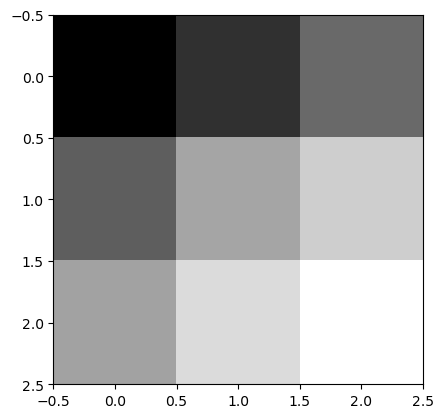

In [2]:
createc_controller = Createc_Controller(None, None, None, None)
img_forward = np.array(createc_controller.stm.scandata(1,4))
#TODO
#Set the pixel of the top-left corner, widht, and height of the anchor
#If the anchor is not used, just set w and h to a small number like below
top_left, w, h = (0,0), 3, 3
#template = img_forward[top_left[1]:top_left[1]+h, top_left[0]:top_left[0]+w]
#plt.imshow(template)

template = img_forward[top_left[1]:top_left[1]+h, top_left[0]:top_left[0]+w]
plt.imshow(template)

### Set the parameters and create a RealExpEnv object

In [3]:
#TODO
step_nm = 0.4 #Set the radius of the manipulation start position relative the the atom start position
goal_nm  = 2 #Set the radius of the manipulation end position relative the the atom start position
max_mvolt = 15 #Set the maximum bias voltage in mV 
max_pcurrent_to_mvolt_ratio = 6E3 #Set the maximum conductance in pA/mV
max_len = 5 #Set maximum episode length
template_max_y = 3 #Set the maximum or minimum row number to search for anchor
#Set the path to load CNN weight for the atom movement classifier
CNN_weight_path = 'C:/LocalUserData/User-data/phys-asp-lab/nian_auto_spm/reaction_rl/training_data_and_model_parameters/model parameters/_atom_move_detector_conv_2460.pth'
current_jump  = 4 #Set the current jump gradient/ std(current) threshold required to take STM scan

#Set STM scan parameters
pixel = 128
im_size_nm = 5 #Image size in nm 
scan_mV = 1000 #bias voltage
x_nm, y_nm = createc_controller.get_offset_nm()
offset_nm = np.array([x_nm, y_nm]) #Set offset to current offset value

#Set manipulation parameters to pull atoms from image edge to center
pull_back_mV = 5 #bias in mV
pull_back_pA = 60000 #current in pA

#Set manipulation limit [left, right, up, down] in nm
manip_limit_nm = np.array([x_nm - 0.5*im_size_nm+0.25, x_nm + 0.5*im_size_nm-0.25, y_nm+0.25, y_nm+im_size_nm-0.25])

env = RealExpEnv(step_nm, max_mvolt, max_pcurrent_to_mvolt_ratio, goal_nm, 
                 template, current_jump, im_size_nm, offset_nm, manip_limit_nm, pixel, 
                 template_max_y, scan_mV, max_len, 
                 CNN_weight_path, 
                 bottom=False, random_scan_rate = 0.8, pull_back_mV = pull_back_mV,
                 pull_back_pA = pull_back_pA)

succeed to connect
Load cnn weight


# Bug test  image size when operating tip_form function, the image size changes

In [4]:
# initial scan_image

result=env.createc_controller.scan_image()


The scan will take 51.1 seconds
offset_test0000 [79.99261284 79.99261284]
offset_test1111 [79.99261284 79.99261284]
offset_test2222 [79.99261284 79.99261284]


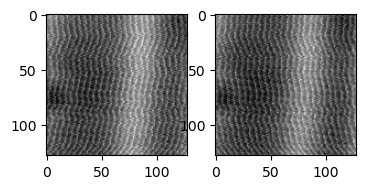

In [40]:
plt.figure(figsize=(4,4))
plt.subplot(1,2,1)
plt.imshow(result[0])
plt.subplot(1,2,2)
plt.imshow(result[1])

# Basic parameters

In [14]:

basic_params=['Delta X [Dac]', 'Delta Y [Dac]', 'Num.X', 'Num.Y', 'Delay X+', 'Delay X-', 'Delay Y', 'DX/DDeltaX','GainX','GainY','GainZ', 'Rotation', 'BiasVolt.[mV]', 'GainPre 10^', 'ScanChannels', 'PlanDx', 'PlanDy', 'OffsetX', 'OffsetY', 'ZPiezoconst', 'XPiezoconst', 'YPiezoconst', 'RepeatRotinc', 'RptBVoltinc', 'Repeatinterval', 'Repeatcounter', 'RepeatXoffset', 'RepeatYoffset', 'Scantype', 'ScanXMode', 'Scancoarse', 'CHMode', 'Channels', 'Preamptype', 'VFBMode', 'RotCMode', 'ScanYMode', 'ScanYDirec']
params=pd.DataFrame(basic_params, columns=['basic params'])
params.loc[:,'values']=[env.createc_controller.stm.getparam(i) for i in basic_params]
# for i in basic_params:
#     print(env.createc_controller.stm.getparam(i))
# print(env.createc_controller.stm.getparam('Length x[A]'))
# print(env.createc_controller.stm.getparam('Length y[A]'))
# print(env.createc_controller.im_size_nm)
# print(env.createc_controller.stm.getparam("GainX"))
# print(env.createc_controller.stm.getparam("GainY"))
# print(env.createc_controller.stm.getparam("GainZ"))

In [15]:
params

,basic params,values
0,Delta X [Dac],77
1,Delta Y [Dac],77
2,Num.X,128
3,Num.Y,128
4,Delay X+,1
5,Delay X-,1
6,Delay Y,1
7,DX/DDeltaX,194
8,GainX,10
9,GainY,10


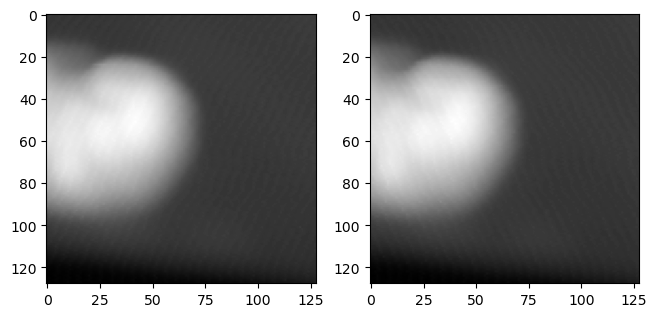

In [5]:
plt.figure(figsize=(16,4))
plt.subplot(1,4,1)
plt.imshow(result[0])
plt.subplot(1,4,2)
plt.imshow(result[1])

# parameters change after tip_form

# Check dissociate manipulation

In [36]:
env.createc_controller.ramp_bias_mV(50)
env.createc_controller.set_Z_approach(12)        
# env.createc_controller.stm.btn_tipform(104, 40)
env.createc_controller.stm.waitms(50)

In [39]:
from collections import namedtuple
dissociate_data = namedtuple('dissociate_data',['time','V','Z','current_series','dI_dV','topography'])

time = env.createc_controller.stm.vertdata(0, 0)  # time
V= env.createc_controller.stm.vertdata(1,1)  # voltage
Z = env.createc_controller.stm.vertdata(2,4) # Z
current_series = env.createc_controller.stm.vertdata(3,3) # current series
dI_dV = env.createc_controller.stm.vertdata(4,0) # dI/dV
topography = env.createc_controller.stm.vertdata(15,4)
data = dissociate_data(time,V,Z,current_series, dI_dV, topography)

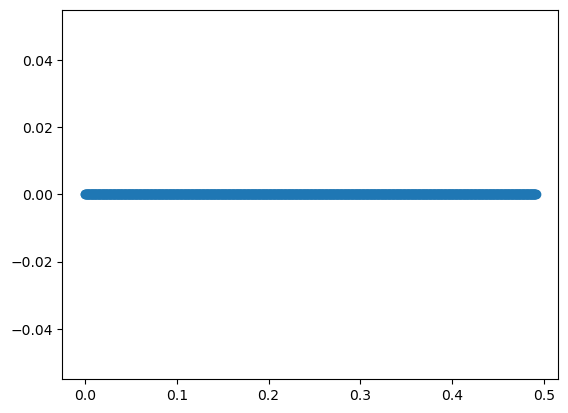

In [40]:
plt.scatter(data.time, data.Z)

In [7]:
data=env.createc_controller.dissassmanipulation(60, 60, 5, 5, 500, np.array([79.99261284, 79.99261284]), 5)

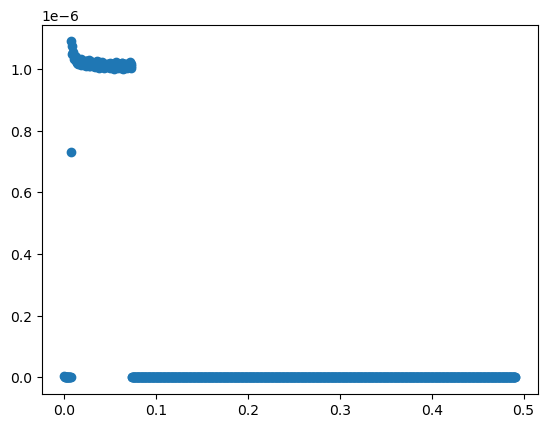

In [6]:
plt.scatter(data.time, data.current)

In [48]:
env.createc_controller.stm.getparam("Latmangain")

'8'

In [50]:
env.createc_controller.stm.getparam("LatmanVolt") #(mV)

'4.99'

In [51]:

env.createc_controller.stm.getparam("Latmanlgi") #(pA)

'7000'

# Check lateral manipulation

In [57]:
mvoltage=5
pcurrent=1000
env.createc_controller.ramp_bias_mV(mvoltage)
preamp_grain = 10**float(env.createc_controller.stm.getparam("Latmangain"))
env.createc_controller.stm.setparam("LatmanVolt",  mvoltage) #(mV)
env.createc_controller.stm.setparam("Latmanlgi", pcurrent*1e-9*preamp_grain) #(pA)
env.createc_controller.stm.latmanip(10, 20, 40, 40)

In [58]:
latmandata = namedtuple('latmandata',['time','x','y','current','dI_dV','topography'])
time = env.createc_controller.stm.latmandata(0, 0)
x= env.createc_controller.stm.latmandata(1,4)
y = env.createc_controller.stm.latmandata(2,4)
current = env.createc_controller.stm.latmandata(3,3)
dI_dV = env.createc_controller.stm.latmandata(4,0)
topography = env.createc_controller.stm.latmandata(15,4)
data = latmandata(time,x,y,current, dI_dV,topography)

In [9]:
data=env.createc_controller.lat_manipulation(60, 60, 72, 58, 5, 500, np.array([79.99261284, 79.99261284]), 5)

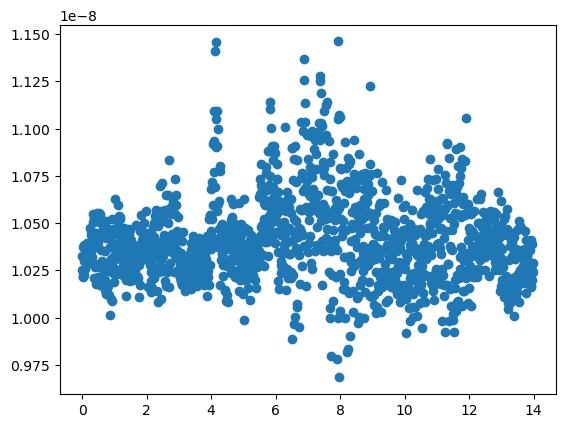

In [63]:
plt.scatter(data.time, data.current)

In [6]:
env.createc_controller.stm.vertdata(0, 0)

((0.0,),
 (0.0004799999878741801,),
 (0.0009599999757483602,),
 (0.0014400000218302011,),
 (0.0019199999514967203,),
 (0.002400000113993883,),
 (0.0028800000436604023,),
 (0.0033599999733269215,),
 (0.0038399999029934406,),
 (0.00431999983265996,),
 (0.004800000227987766,),
 (0.005280000157654285,),
 (0.005760000087320805,),
 (0.006240000016987324,),
 (0.006719999946653843,),
 (0.007199999876320362,),
 (0.007679999805986881,),
 (0.0081599997356534,),
 (0.00863999966531992,),
 (0.009119999594986439,),
 (0.009600000455975533,),
 (0.010080000385642052,),
 (0.01056000031530857,),
 (0.01104000024497509,),
 (0.01152000017464161,),
 (0.012000000104308128,),
 (0.012480000033974648,),
 (0.012959999963641167,),
 (0.013439999893307686,),
 (0.013919999822974205,),
 (0.014399999752640724,),
 (0.014879999682307243,),
 (0.015359999611973763,),
 (0.01583999954164028,),
 (0.0163199994713068,),
 (0.01679999940097332,),
 (0.01727999933063984,),
 (0.01775999926030636,),
 (0.018239999189972878,),
 (0.01871

In [16]:
print(env.createc_controller.stm.getparam('Length x[A]'))
print(env.createc_controller.stm.getparam('Length y[A]'))
print(env.createc_controller.im_size_nm)
print(env.createc_controller.stm.getparam("GainX"))
print(env.createc_controller.stm.getparam("GainY"))
print(env.createc_controller.stm.getparam("GainZ"))

149.9557
149.9557
15
10
10
10


In [19]:
env.createc_controller.offset_nm=np.array([110,  50])

In [21]:
results=env.createc_controller.scan_image()   # problem: long scanning time, even never terminate

The scan will take 127.8 seconds
offset_test0000 [110  50]
offset_test1111 [110  50]
offset_test2222 [110  50]


# change parameters

In [21]:
env.createc_controller.stm.setparam('GainX',10)
GainX = float(env.createc_controller.stm.getparam("GainX"))
env.createc_controller.stm.setparam('GainY',10)
GainY = float(env.createc_controller.stm.getparam("GainY"))
env.createc_controller.stm.setparam('GainZ',3)
GainZ = float(env.createc_controller.stm.getparam("GainZ"))
env.createc_controller.im_size_nm=5
# env.createc_controller.stm.setparam('Delta X [Dac]',59)
env.createc_controller.get_Delta_X(5)

59

In [1]:
env.createc_controller.scan_image() # problem: long scanning time, even never terminate, although change the paramters as this way

#  check what happens

In [30]:
env.createc_controller.stm.scanstart()
env.createc_controller.stm.scanstatus  # always keep the scanstatus as 2 i.e. running state


2

In [34]:

env.createc_controller.stm.scanstart() #Starts a new STM scan. Similar to pressing the button Scanstart
print('aaaa')
while True:

    scanstatus = env.createc_controller.stm.scanstatus
    print('bbb')
    if scanstatus!=2:
        break


# Test spiral trajectory

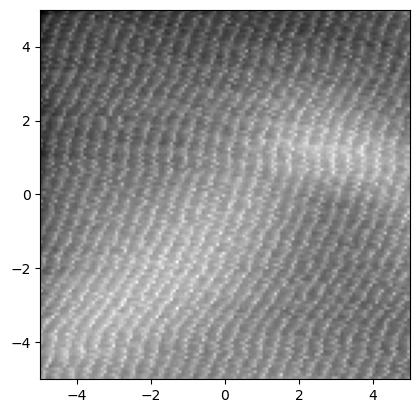

In [63]:
plt.imshow(results[0], extent=[-5, 5, -5, 5])


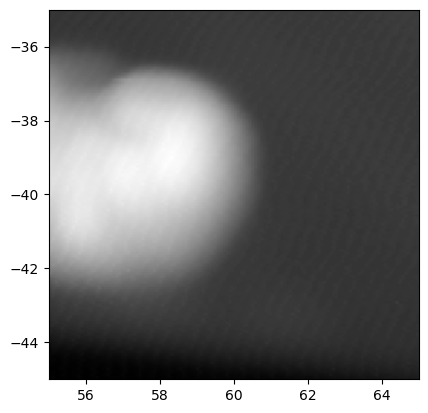

In [8]:
plt.imshow(result[0], extent=[new_x_a-5, new_x_a+5, new_y_a-5, new_y_a+5])

starting new approach area...
-4 0 80.0 40 40.0 80.0
-3 -2 66.05551275463989 30 36.05551275463989 66.05551275463989
-3 2 66.05551275463989 30 36.05551275463989 66.05551275463989
-2 -3 66.05551275463989 30 36.05551275463989 66.05551275463989
-2 3 66.05551275463989 30 36.05551275463989 66.05551275463989
0 -4 66.05551275463989 40 40.0 80.0
0 4 66.05551275463989 40 40.0 80.0
2 -3 66.05551275463989 30 36.05551275463989 66.05551275463989
2 3 66.05551275463989 30 36.05551275463989 66.05551275463989
3 -2 66.05551275463989 30 36.05551275463989 66.05551275463989
3 2 66.05551275463989 30 36.05551275463989 66.05551275463989
4 0 66.05551275463989 40 40.0 80.0
The scan will take 127.1 seconds
offset_test0000 [20 20]
offset_test1111 [20 20]
offset_test2222 [20 20]
20 30 35
starting new approach area...
-4 0 80.0 40 40.0 80.0
-3 -2 66.05551275463989 30 36.05551275463989 66.05551275463989
-3 2 66.05551275463989 30 36.05551275463989 66.05551275463989
-2 -3 66.05551275463989 30 36.05551275463989 66.05551

The scan will take 127.1 seconds
offset_test0000 [120 120]
offset_test1111 [120 120]
offset_test2222 [120 120]
120 90 35
starting new approach area...
-3 2 66.05551275463989 30 36.05551275463989 66.05551275463989
-2 3 66.05551275463989 30 36.05551275463989 66.05551275463989
0 4 66.05551275463989 40 40.0 80.0
2 3 66.05551275463989 30 36.05551275463989 66.05551275463989
3 2 66.05551275463989 30 36.05551275463989 66.05551275463989
The scan will take 127.1 seconds
offset_test0000 [90 90]
offset_test1111 [90 90]
offset_test2222 [90 90]
90 110 35
starting new approach area...
-3 2 66.05551275463989 30 36.05551275463989 66.05551275463989
-2 3 66.05551275463989 30 36.05551275463989 66.05551275463989
0 4 66.05551275463989 40 40.0 80.0
2 3 66.05551275463989 30 36.05551275463989 66.05551275463989
3 2 66.05551275463989 30 36.05551275463989 66.05551275463989
The scan will take 127.1 seconds
offset_test0000 [60 60]
offset_test1111 [60 60]
offset_test2222 [60 60]
60 130 35
starting new approach area.

The scan will take 127.1 seconds
offset_test0000 [200 200]
offset_test1111 [200 200]
offset_test2222 [200 200]
200 60 35
starting new approach area...
-3 -2 66.05551275463989 30 36.05551275463989 66.05551275463989
-2 -3 66.05551275463989 30 36.05551275463989 66.05551275463989
0 -4 66.05551275463989 40 40.0 80.0
2 -3 66.05551275463989 30 36.05551275463989 66.05551275463989
2 3 66.05551275463989 30 36.05551275463989 66.05551275463989
3 -2 66.05551275463989 30 36.05551275463989 66.05551275463989
3 2 66.05551275463989 30 36.05551275463989 66.05551275463989
The scan will take 127.1 seconds
offset_test0000 [170 170]
offset_test1111 [170 170]
offset_test2222 [170 170]
170 40 35
starting new approach area...
-2 -3 66.05551275463989 30 36.05551275463989 66.05551275463989
0 -4 66.05551275463989 40 40.0 80.0
2 -3 66.05551275463989 30 36.05551275463989 66.05551275463989
3 -2 66.05551275463989 30 36.05551275463989 66.05551275463989
The scan will take 127.1 seconds
offset_test0000 [150 150]
offset_t

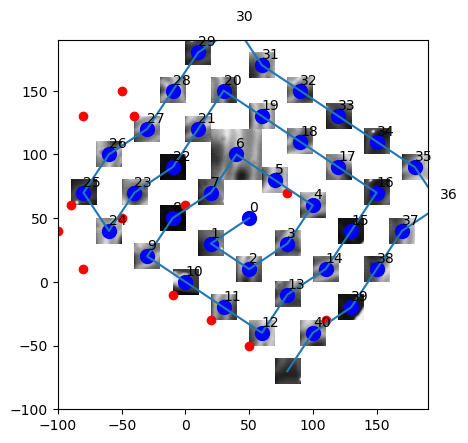

In [20]:
new_x_a=50
new_y_a=50
radius=35
check_similarity=[]
check_similarity.append([new_x_a, new_y_a])
upper_limit_move=400

found=False
epoch=0

# plt.figure(figsize=(16,160))
# plt.subplot(40,4,1)
# plt.imshow(results[0])




while not found:
    plt.text(new_x_a, new_y_a+5, epoch)
#     env.switch_approach_area()
#     env.ForbiddenArea(forbiden_radius=radius)
#     plt.gca().add_patch(patches.Circle((new_x_a, new_y_a), radius, fill=False))
    new_x_a, new_y_a=env.GetNextGoodClosest(new_x_a, new_y_a, initial_x=50, initial_y=50, forbiden_radius=radius, upper_limit_move=upper_limit_move,approach_limit=[-130, 230, -130, 230],check_similarity=check_similarity) 
#     plt.subplot(40,4,epoch+1)
    if epoch+1==6:
        env.createc_controller.im_size_nm=env.createc_controller.im_size_nm*2
        env.createc_controller.offset_nm=np.array([new_x_a, new_x_a])
        result=env.createc_controller.scan_image()
        plt.imshow(result[0], extent=[new_x_a-10*2, new_x_a+10*2, new_y_a-10*2, new_y_a+10*2])
        env.createc_controller.im_size_nm=env.createc_controller.im_size_nm/2
    else:
        env.createc_controller.offset_nm=np.array([new_x_a, new_x_a])
        result=env.createc_controller.scan_image()
        plt.imshow(result[0], extent=[new_x_a-10, new_x_a+10, new_y_a-10, new_y_a+10])
        
#     plt.imshow(result[0], extent=[new_x_a-10, new_x_a+10, new_y_a-10, new_y_a+10])
    
    print(new_x_a, new_y_a, radius)
    
    if  new_x_a==None:
        
        new_x_a, new_y_a=check_similarity[-1][0], check_similarity[-1][1]
        plt.gca().add_patch(patches.Circle((new_x_a, new_y_a), radius, fill=False, color='yellow'))
        radius=radius*2
        env.max_radius=300
        upper_limit_move=upper_limit_move+20000
#         plt.gca().add_patch(patches.Circle((new_x_a, new_y_a), radius, fill=False, color='yellow'))    
    else:
        radius=35
        env.max_radius=150
        upper_limit_move=400
#         plt.gca().add_patch(patches.Circle((new_x_a, new_y_a), radius, fill=False))
    
    if radius>1000:
        break
        
    check_similarity.append([new_x_a, new_y_a])
        
#     plt.gca().add_patch(patches.Circle((new_x_a, new_y_a), radius, fill=False))
    if new_y_a<-59:
        found=True
    epoch=epoch+1
        
plt.plot([i[0] for i in check_similarity], [i[1] for i in check_similarity])
plt.xlim(-100, 190)
plt.ylim(-100, 190)
plt.savefig('path2.png')

### Create a sac_agent object

In [16]:
#TODO
batch_size= 64 #Set minibatch size
LEARNING_RATE = 0.0003 #Set learning rate

#Set the action space range
ACTION_SPACE = namedtuple('ACTION_SPACE', ['high', 'low'])
action_space = ACTION_SPACE(high = torch.tensor([1,1,1,1,1,1]), low = torch.tensor([-1,-1,-1,-1,1/3,1/2]))

#Initialize the soft actor-critic agent
alpha = 1.0
agent = sac_agent(num_inputs = 4, num_actions = 6, action_space = action_space, device=device, hidden_size=256, lr=LEARNING_RATE,
                 gamma=0.9, tau=0.005, alpha=alpha)

### Create a HerReplayMemory object
Here we use the hindsight experience replay with the 'future' strategy to sample goals

In [17]:
#TODO
replay_size=1000000 #Set memory size

memory = HerReplayMemory(replay_size, env, strategy = 'future')

In [18]:
memory.n_sampled_goal

2

### Create a Episode_Memory object
The episode memory class is used to store all the relavant information in each training episode, including the STM images, state, action, reward, etc.

In [19]:
episode_memory = Episode_Memory()
#TODO
#Set the folder name to store training data and neural network weight
folder_name =  'C:/LocalUserData/User-data/phys-asp-lab/nian_auto_spm/test_nian'

### Set the hyperparameters for Emphasize Recent Experience replay

In [20]:
c_k_min = 500
eta = 0.994
max_ep_len = max_len

### Create empty lists for logging performances

In [21]:
episode_rewards, alphas, precisions, episode_lengths = [], [], [], []
avg_episode_rewards, avg_alphas, avg_precisions, avg_episode_lengths = [], [], [], []

# Define the training function

In [ ]:
def sac_train(max_steps = max_len, num_episodes = 50, episode_start = 0):
    """
    Collect training data and train the RL agent

    Parameters
    ----------
    max_steps: int
            maximum steps in an episode
            
    num_episodes: int
            Train for this many episodes
    
    episode_start: int
            Index to use for the starting episode

    Returns
    -------
    None : None
    """
    for i_episode in range(episode_start,episode_start+num_episodes):
        print('Episode:', i_episode)
        episode_reward, episode_steps = 0, 0
        done = False
        state, info = env.reset(update_conv_net=False)
        show_reset(env.img_info, env.atom_start_absolute_nm, env.destination_absolute_nm,
                   env.template_nm, env.template_wh)
        episode_memory.update_memory_reset(env.img_info, i_episode, info)
        
        for step in range(max_steps):
            action = agent.select_action(state)
            old_atom_nm = env.atom_absolute_nm
            next_state, reward, done, info = env.step(action)
            episode_steps+=1
            episode_reward+=reward
            mask = float(not done)
            memory.push(state,action,reward,next_state,mask)
            episode_memory.update_memory_step(state, action, next_state, reward, done, info)
            show_step(env.img_info, info['start_nm']+old_atom_nm, info['end_nm']+old_atom_nm,
                        env.atom_absolute_nm, env.atom_start_absolute_nm, 
                        env.destination_absolute_nm, action[4]*env.max_mvolt, 
                        action[5]*env.max_pcurrent_to_mvolt_ratio*action[4]*env.max_mvolt, 
                        env.template_nm, env.template_wh)
            print('step:', step,'reward', reward, 'precision:', env.dist_destination)
            if done:
                episode_memory.update_memory_done(env.img_info, env.atom_absolute_nm, env.atom_relative_nm)
                episode_memory.save_memory(folder_name)
                print('Episode reward:', episode_reward)
                break
            else:                
                state=next_state
             
        if (len(memory)>batch_size):
            episode_K = int(episode_steps)
            for k in range(episode_K):
                c_k = max(int(memory.__len__()*eta**((k)*(1000/episode_K))), 500)
                agent.update_parameters(memory, batch_size, c_k)
        
        episode_rewards.append(episode_reward)
        alphas.append(agent.alpha.item())
        precisions.append(env.dist_destination)
        episode_lengths.append(episode_steps)
        avg_episode_rewards.append(np.mean(episode_rewards[-min(100,len(episode_rewards)):]))
        avg_alphas.append(np.mean(alphas[-min(100, len(alphas)):]))
        avg_precisions.append(np.mean(precisions[-min(100, len(precisions)):]))
        avg_episode_lengths.append(np.mean(episode_lengths[-min(100, len(episode_lengths)):]))
        
        if (i_episode+1)%2==0:
            plot_graph(episode_rewards, precisions, alphas, episode_lengths,
                      avg_episode_rewards, avg_alphas, avg_precisions, avg_episode_lengths)
            
        if (i_episode)%20 == 0:
            torch.save(agent.critic.state_dict(), '{}/_critic_{}.pth'.format(folder_name,i_episode))
            torch.save(agent.policy.state_dict(), '{}/_policy_{}.pth'.format(folder_name,i_episode))
            torch.save(agent.alpha, '{}/_alpha_{}.pth'.format(folder_name,i_episode))
            torch.save(env.atom_move_detector.conv.state_dict(), '{}/_atom_move_detector_conv_{}.pth'.format(folder_name

In [22]:
max_steps = 5
num_episodes = 50
episode_start = 0

In [ ]:
done_dect_atom=False


In [ ]:
# find a section to condition tip
start_crash_hole=0
approach_z=2

def tip_cond_area(center_x=0, center_y=0, approach_area_length=800, cond_area_length=200, margin=20):
    cond_area_center_x, cond_area_center_y=center_x-approach_area_length+cond_area_length+margin, center_y-approach_area_length+cond_area_center_y+margin
    return cond_area_center_x, cond_area_center_y, cond_area_length

env.default_max_radius_cellsize(cellsize=20, max_radius=200)
points=env.computeLocationIDs()
cond_area_center_x, cond_area_center_y, cond_area_length=tip_cond_area()

env.createc_controller.ramp_bias_mV(-1.2)
env.createc_controller.tip_form(approach_z, cond_area_center_x+points[start_crash_hole][0]*cellsize,cond_area_center_y+points[start_crash_hole][1]*cellsize)
print(env.createc_controller.im_size_nm)
start_crash_hole=start_crash_hole

In [ ]:
start_x = 0
start_y = 0
tip_x = 0
tip_y = 0
check_similarity=None
check_similarity.append([tip_x, tip_y])
radius = 35
upper_limit_move=400
env.max_radius=150

image_forward = info['img_info']['img_forward']
image_backward =info['img_info']['img_backward']


# dectect atoms
isAtom = False

# debris
debris_thres = 6
DebresCounter = 0
noDebris = False

# Crash dectected
crash_thres = 1e-25 
approach_z = 4
noCrash = False

while not isAtom or not noDebris or not noCrash:
    
    # detect atoms
    atom_forward = blob_detection(info[img_forward])[0]

    if len(atom_forward)>0:
        isAtom = True

    # detect debris
    noDebris =  ((np.max(image_forward) - np.min(image_forward)) < debris_thres) 
    
    # dectect crash
    noCrash = (np.max(img_forward)-np.min(img_forward) )< crash_thres and (np.mean(img_forward)>0)
    
    if isAtom and noDebris and noCrash:
        continue                
    else:
        tip_x, tip_y=env.GetNextGoodClosest(tip_x, tip_y, initial_x=start_x, initial_y=start_y, forbiden_radius=radius, upper_limit_move=upper_limit_move,approach_limit=[-180, 180, -180, 180],check_similarity=check_similarity) 
        if tip_x==None:
            tip_x, tip_y=check_similarity[-1][0], check_similarity[-1][1]
            image=env.set_newtip_pos(tip_x, tip_y)
            image_forward, image_backward =image[0], image[1]
            radius=radius*2
            env.max_radius=env.max_radius*2
            upper_limit_move=upper_limit_move+20000
        else:
            radius=35
            upper_limit_move=400
            env.max_radius=150
                
    
            
            
    check_similarity.append([tip_x, tip_y])        
    if radius>280:
        print('there is no section satisfying the demand within radius of 280 nm')
        break

    

        
        
    
    



# tip condition section

In [5]:
center_x=0
center_y=0
approach_area_length=800
def tip_cond_area(center_x=0, center_y=0, approach_area_length=800, cond_area_length=200, margin=20):
    cond_area_center_x, cond_area_center_y=center_x-approach_area_length+cond_area_length+margin, center_y-approach_area_length+cond_area_center_y+margin
    return cond_area_center_x, cond_area_center_y, cond_area_length


    
    

# Condition probe

In [ ]:
env.createc_controller.stm.setparam('TipForm_Volt', -3) # Set the bias voltage for the atom manipulation(unit V)

env.createc_controller.stm.setparam('TipForm_Z', 0.0) # Set the z position for the atom manipulation(unit angstrom)

env.createc_controller.stm.setparam('Tip_Delay', 0.4915) # Set the delay time for the atom manipulation(unit s)
env.createc_controller.stm.setparam('Tip_Latddx', 833) # Set the lateral ddx for the atom manipulation(unit angstrom/ms^2)
env.createc_controller.stm.setparam('Tip_LatDelay', 20) # Set the lateral delay for the atom manipulation(unit ms)
env.createc_controller.stm.setparam('Tip_Gain', 6) # Set the gain for the atom manipulation(unit 1)
env.createc_controller.stm.setparam('TipForm_Zoffset', 0.0) # Set the z offset for the atom manipulation(unit angstrom)



In [ ]:
tip_condition_actions={'stall': [0, 0],
                      'soft pulse pos':[0, 2.5],
                      'medium pulse pos': [0, 4.0],
                      'soft pulse neg': [0 , -2.5], 
                      'medium pulse neg': [0, -4],
                      'strong pulse neg': [0, -8],
                      'very soft dip': [0, -8],
                      'soft dip 1': [-0.80, 0.02],
                      'soft dip 2': [-1.2, 0.02],
                      'soft dip 3': [-1.8, 0.02],
                      'medium soft': [-2.5, 0.02],
                      'strong dip': [-5.0, 0.02]
                      }


In [ ]:
num_no_done = 0
episode_start=0
max_episode = 10
num_episodes=50
for i_episode in range(episode_start,episode_start+num_episodes):
    print('Episode:', i_episode)
    episode_reward, episode_steps = 0, 0
    done = False
    print('offffset0000',env.offset_nm)
    state, info = env.reset(update_conv_net=False)
    print(state, info)
    
 # detect atoms   

#  no debris

# crash or no probe-atom contact
    
    
    show_reset(env.img_info, env.atom_start_absolute_nm, env.destination_absolute_nm,
               env.template_nm, env.template_wh)
    episode_memory.update_memory_reset(env.img_info, i_episode, info)
    print('offffset1111',env.offset_nm)
    


    for step in range(max_steps):
        action = agent.select_action(state)
        old_atom_nm = env.atom_absolute_nm
        print('offffset2222',env.offset_nm)
        next_state, reward, done, info = env.step(action)
        print('offffset3333',env.offset_nm)
        episode_steps+=1
        episode_reward+=reward
        mask = float(not done)
        memory.push(state,action,reward,next_state,mask)
        episode_memory.update_memory_step(state, action, next_state, reward, done, info)
        print(info)
        show_step(env.img_info, info['start_nm']+old_atom_nm, info['end_nm']+old_atom_nm,
                    env.atom_absolute_nm, env.atom_start_absolute_nm, 
                    env.destination_absolute_nm, action[4]*env.max_mvolt, 
                    action[5]*env.max_pcurrent_to_mvolt_ratio*action[4]*env.max_mvolt, 
                    env.template_nm, env.template_wh)
        print('step:', step,'reward', reward, 'precision:', env.dist_destination)
        if done:
            episode_memory.update_memory_done(env.img_info, env.atom_absolute_nm, env.atom_relative_nm)
            episode_memory.save_memory(folder_name)
            print('Episode reward:', episode_reward)
            break
        else:                
            state=next_state
            
    # if manipulation fails N times, adjust tip conditioning
    
    


        

    if (len(memory)>batch_size):
        episode_K = int(episode_steps)
        for k in range(episode_K):
            c_k = max(int(memory.__len__()*eta**((k)*(1000/episode_K))), 500)
            agent.update_parameters(memory, batch_size, c_k)

In [ ]:
env.createc_controller.stm.scanstop()

### Define the training function

In [11]:
env.dist_destination=0.3934795995776328